# Songwriter's Sketchpad:
### Using Convolutional Neural Network to evaluate original music by comparing against existing songs

# Concept

Songwriter's sketchpad is a Machine Learning tool that helps songwriter's in their creativity process. The main feature is using the artist's original track to generate similar songs from the database so the artist can get a sense of how his or her work compares to what is already out there. The application works similarly to a Content-Based Recommendation engine. It applies convolutional neural network in the form of an autoencoder for feature extraction, and cosine similarity for the recommendation system.

# Method

For the prototype, I used a personal collection of 80 Gigabytes of mp3 for my data to train my models. There are many methods for music information retrieval, like labeling the audio by beats per minute, mode, key or pitch, etc., the scope depends on the features that are important for the end user. The method I chose was to convert my mp3s to spectrograms, which is a visual representation of the audio that captures the frequency content with respect to time. The images are a holistic view of the audio file as it encapsulates all the frequency complexities of a song, and the energy throughout depicted by the contrast of the color bands.

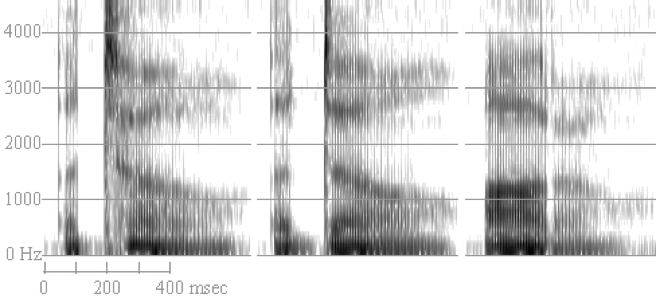

# Dataset: Convert MP3 to Spectrograms

I used librosa to convert mp3 to mel spectrograms, which produces a 2D array that is 128 rows by anywhere between 3000 to 40000 columns, depending on the length of the song. Log-scaled mel-spectrograms is the current "standard" for use with Convolutional Neural Networks. It was the most commonly used in Audio Event Detection and Audio Scene Classification literature between 2015-2018. 


**Import the preprocessing toolkits**

In [2]:
from __future__ import print_function
import os
# Librosa for audio, and the display module for visualization
import librosa
import librosa.display

In [3]:
import numpy as np
import IPython.display

# Pickling is extremely important in loading large files
import pickle
import pandas as pd

**First, retrive the song files from database and remove files that cannot be converted into spectrograms**

In [3]:
# Use os to walk through file folders and retrive file names
file_paths = []
for root, dirs, files in os.walk("/Users/carrieqiu/Desktop/Music", topdown=False):
    for name in files:
        file_paths.append(os.path.join(root, name))

In [6]:
to_delete = []
for i in file_paths:
    if '.DS_Store' in i:
        to_delete.append(i)
    if '.m4a' in i:
        to_delete.append(i)

for i in to_delete:
    file_paths.remove(i)

**Write a function that takes in audio_path and converts into spectrogram. Store all spectrograms into pickle files.**

In [ ]:
music_data ={}

for i in range(len(file_paths)):
    audio_path = file_paths[i]
    y, sr = librosa.load(audio_path)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    music_data[file_paths[i]] = log_S
    print(i)
    if (i+1)%100==0:
        with open('music_database{}.pkl'.format(i+1), 'wb') as picklefile:
            pickle.dump(music_data, picklefile)
        music_data ={}

**Example Spectrogram**

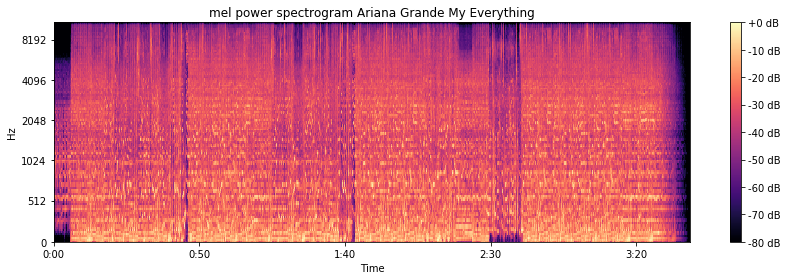

In [28]:
# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram Ariana Grande My Everything')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()


# Preprocessing: Model Input

**Reshape and Rescale the data in preparation for feeding into the autoencoder**

This step is quite important. Be sure to preprocess all the matrices in all the pickled files one by one before combining them because the files are very large, so combining them before preprocessing will crash the kernel. Select all the values (matrices) in the pickled dictionaries, resize-rescale-reshape them, and append to a list to be saved into new pickled file that contains the entire preprocessed spectrograms of the entire music library. 

- resize: use opencv to convert to image size
- rescale: convert values to between 0 and 1 
- reshape: CNN can only take in 3D inputs so the matrices have to be reshaped by adding 1 for the 3rd dimension.

The proprocessing can be done in opencv by using the method resize. Most CNNs take in image size around 200, so the spectrograms with lengths in the tens of thousands needs to be reduced dramatically to the same shape. The final spectrogram shape is determined to be (128, 256) to match a regular image that's usually fed into a CNN model. Then the matrices are rescaled by dividing by the largest value to quicken the process of gradient descent once the corpus is fed into the model. Pickle and save the proprocessed spectrogram corpus.

In [10]:
import cv2

In [132]:
new_k=[]
for i in sorted([f for f in os.listdir('music_pickled') if '.pkl' in f]):
    with open("music_pickled/"+i, 'rb') as picklefile:
        music_train = pickle.load(picklefile)
        for k in music_train.values():
            resize = (cv2.resize(k, dsize=(256, 128))/-80).reshape(128, 256, 1)
            new_k.append(resize)
new_k=np.array(new_k)
with open('compiled_autoinput.pkl', 'wb') as picklefile:
    pickle.dump(new_k, picklefile)            
            

Open the pickled preprocessed spectrogram database to be fed into Autoencoder Model.

In [4]:
with open('compiled_autoinput.pkl', 'rb') as picklefile:
    music_train = pickle.load(picklefile)

In [10]:
music_train.shape

(7400, 128, 256, 1)

Similarly, the music pathnames need to be compiled into a list in order to match metadata later to the encoded layers.

In [145]:
new_path = []
for i in sorted([f for f in os.listdir('music_pickled') if '.pkl' in f]):
    with open("music_pickled/"+i, 'rb') as picklefile:
        music_train = pickle.load(picklefile)
        for k in music_train.keys():
            new_path.append(k)
with open('compiled_keys.pkl', 'wb') as picklefile:
    pickle.dump(new_path, picklefile)

In [5]:
with open('compiled_keys.pkl', 'rb') as picklefile:
    music_paths = pickle.load(picklefile)

# Model: Feature Extraction Using Autoencoder (Convolutional Neural Network)

In [5]:
## load the libraries 
from keras.models import Input
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Using TensorFlow backend.


**Layout the Autoencoder architecture.**

In [7]:
input_spec = Input(shape=(128,256,1))

#Encoding Layer:
x = Conv2D(512, (3, 3), activation='relu', padding='same')(input_spec)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded_layer')(x)

# Decoding layers
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


# Create the model
autoencoder = Model(input_spec, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [8]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 256, 512)     5120      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 128, 512)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 128, 64)       294976    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 64, 16)        9232      
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 16, 32, 16)        0         
__________

**Train the Model.**
Set up hyperparameters, and feed inputs into the Autoencoder.

In [9]:
epochs = 20
batch_size = 20
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [10]:
history = autoencoder.fit(
    music_train, music_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, 
    callbacks=[early_stopping], verbose=1)


Train on 5920 samples, validate on 1480 samples
Epoch 1/20
5920/5920 [==============================] - 2885s 487ms/step - loss: 0.0119 - val_loss: 0.0088
Epoch 2/20
5920/5920 [==============================] - 2881s 487ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 3/20
5920/5920 [==============================] - 2875s 486ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 4/20
5920/5920 [==============================] - 2881s 487ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 5/20
5920/5920 [==============================] - 2884s 487ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 6/20
5920/5920 [==============================] - 2874s 485ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 7/20
5920/5920 [==============================] - 2899s 490ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 8/20
5920/5920 [==============================] - 2906s 491ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 9/20
5920/5920 [==============================] - 2882s 487ms/step - loss: 0.0066 - val_lo

Save model in a "feature mapper".

In [11]:
autoencoder.save('full_model.h5')

In [12]:
inputs = autoencoder.input

In [13]:
outputs = autoencoder.get_layer('encoded_layer').output

In [14]:
feature_mapper = Model(inputs, outputs )

In [15]:
feature_mapper.save('fullmodel_mapper')

Load "feature_mapper" and use predict function to get all the encoded middle layers for distance comparison.

In [ ]:
feature_mapper = load_model('fullmodel_mapper')

In [8]:
latent_layers = feature_mapper.predict(music_train, verbose = 1)

7400/7400 [==============================] - 116s 16ms/step


In [11]:
with open('latent_layers.pkl', 'wb') as picklefile:
    pickle.dump(latent_layers, picklefile)

In [7]:
with open('latent_layers.pkl', 'rb') as picklefile:
    latent_layers = pickle.load(picklefile)

In [7]:
latent_layers.shape

(7400, 16, 32, 16)

# Scrape Lyrics to Append to Audio Features 

To combine audio feature analysis with lyrical features, first import all path names and preprocess by Artist and Song. Put all the metadata in a Dataframe.

In [13]:
with open("compiled_keys.pkl", 'rb') as picklefile: 
    file_names = pickle.load(picklefile)

artist_list = []
for i in file_names:
    artist = i.split("/")[5]
    artist_list.append(artist)

song_list = []
for i in file_names:
    song = i.split("/")[7].replace('.mp3','')[3:]
    song_list.append(song)

df_metadata = pd.DataFrame(list(zip(artist_list, song_list)), columns = ['artist','song'])

Use metadata from above to scrape wikilyrics for lyrics in the mp3 dataframe

In [29]:
from PyLyrics import *
from time import sleep
import numpy as np
import pandas as pd
import pprint
import warnings
from multiprocessing import Pool
from bs4 import BeautifulSoup
from tqdm import tqdm
import time
import requests

In [30]:
def query_wikilyrics(query):
    artist = query[0]
    title = query[1]
    try:
        try:
            return PyLyrics.getLyrics(artist,title)
        except requests.exceptions.ConnectionError:
            sleep(1)
            return PyLyrics.getLyrics(artist,title)
    except ValueError:
        return None

In [31]:
def pull_lyrics_wikilyrics(df):
    search_queries = list(zip(list(df['artist']),list(df['song'])))
    
    print(f'Scraping lyrics for {len(search_queries)} tracks.')
    
    pool = Pool(50)
    if __name__ == '__main__':   
        lyrics = list(tqdm(pool.imap(query_wikilyrics, search_queries), total = len(search_queries)))
    pool.terminate()
    pool.join()

    print(f'Finished')
    
    df['lyrics'] = lyrics
    
    return df

In [ ]:
df_meta_lyrics = pull_lyrics_wikilyrics(df_metadata)

In [35]:
df_meta_lyrics.shape

(7400, 3)

Append encoded layers of the audio features to the lyrics dataframe to make the **complete database**.

In [54]:
df_meta_lyrics['latent']=[i for i in latent_layers]

with open('full_dataframe.pkl', 'wb') as picklefile:
    pickle.dump(df_meta_lyrics, picklefile)

# Load Full Dataframe

In [8]:
with open('full_dataframe.pkl', 'rb') as picklefile:
        df_train = pickle.load(picklefile)

In order to perform cosine distance calculations, the encoded layers need to be flattened to 1D from 3D. Do this through the reshape method and compile all the latent layers into a list and pickle the file. 

In [17]:
latent_2D = lambda row: row['latent'].reshape(-1)
df_train['latent']=df_train.apply(latent_2D, axis=1)

latent_corpus = np.array(df_train.latent.tolist())

with open('full_latent_corpus.pkl', 'wb') as picklefile:
    pickle.dump(latent_corpus, picklefile)

In [16]:
latent_corpus.shape

(7400, 8192)

In [29]:
df_train.shape

(7400, 4)

# Recommendation Engine: Audio

In [9]:
from scipy import spatial

In [11]:
def similarity_audio(original_music):

    # STEP 1: Convert the spectrogram of the original to the resized and rescaled version
            # and get latent layer using feature_mapper

    y, sr = librosa.load(original_music)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    
    # Convert the spectrogram of the original to the resized and rescaled version,
    # and reshape to be passed into latent layer
    original_compressed = (cv2.resize(log_S, dsize=(256, 128))/-80).reshape(1, 128, 256, 1) 
    
    # Generate the latent layer of the original song using feature mapper, and reshape for distance comparison.
    original_latent = feature_mapper.predict(original_compressed).reshape(-1)
    
        
    # STEP 2: Get corpus of latent layers for distance comparison.
            # All of this takes a bit of time so make sure to reduce the time taken to generate results by 
                # loading pickled corpus of the latent layer database

    with open('full_latent_corpus.pkl', 'rb') as picklefile:
        latent_corpus = pickle.load(picklefile)
        
    with open('full_dataframe.pkl', 'rb') as picklefile:
        df_train = pickle.load(picklefile)
    
    # STEP 3: Distance comparison:
    distance = spatial.distance.cdist(original_latent.reshape(1,-1), latent_corpus, metric='cosine')
        
    # STEP 4: Get index of shortest distances in order to retrieve name of songs
    top_10 = pd.DataFrame([df_train.iloc[index,:2] for index in distance[0].argsort()[:10]])
    
    return top_10

In [11]:
similarity_audio('Chelsea.mp3')

,artist,song
2744,Trent Dabbs,Can I Cross Your Mind
7366,Yo La Tengo,My Little Corner Of The World
6982,Demi Lovato,In Case
5307,Ab-Soul,The Book Of Soul
7377,Fiona Apple,Anything We Want
6188,John Legend,So Gone
7384,May Erlewine,The Turning
6873,Don McLean,La La I Love You
6594,Arcade Fire,Neighborhood #4 (7 Kettles)
2395,James Blunt,You're Beautiful


In [22]:
similarity_audio('I Gotta Speak My Mind (Trash Can Dream).mp3')

,artist,song
5368,Pedro the Lion,Transcontinental
5100,The Verve,On Your Own
217,Lily Allen,Everything's Just Wonderful
6850,Drake,Best I Ever Had (Clean)
1749,Belle & Sebastian,Sunday's Pretty Icons
5830,Ou Est Le Swimming Pool,Our Lives
3117,The Decemberists,Here I Dreamt I Was an Architect
3183,Oasis,Cast No Shadow.m4a
5834,Ou Est Le Swimming Pool,Jackson's Last Stand
4832,Electric Light Orchestra,9 The Lights Go Down


In [15]:
similarity_audio('Indigo (Trash Can Dream).mp3')

,artist,song
5215,Vitamin String Quartet,Saving Grace (Original Composition)
3552,Miley Cyrus,Rooting For My Baby
7392,May Erlewine,Sweet Drag
5211,Vitamin String Quartet,Muscle Museum
2589,Jacques Brel,Je Ne Sais Pas
2169,Yeah Yeah Yeahs,Little Shadow (Acoustic)
7366,Yo La Tengo,My Little Corner Of The World
5615,Alison Krauss and Union Station,Doesn't Have To Be This Way
5693,McFly,Walk in the Sun
5220,Vitamin String Quartet,Sunburn


In [16]:
similarity_audio('Out On The Sea | Trash Can Dream.mp3')

,artist,song
3203,Five For Fighting,Maybe I
5471,Avril Lavigne,Slipped Away
211,Lily Allen,Who'd Have Known
2425,James Blunt,Give Me Some Love
2395,James Blunt,You're Beautiful
139,Ingrid Michaelson,Starting Now
2391,James Blunt,Wisemen
2398,James Blunt,Billy
773,ATC,Mistake No. 2
2752,Trent Dabbs,Inside These Lines


In [17]:
similarity_audio('The One with the Gun.mp3')

,artist,song
2169,Yeah Yeah Yeahs,Little Shadow (Acoustic)
136,Ingrid Michaelson,Around You
5215,Vitamin String Quartet,Saving Grace (Original Composition)
2170,Yeah Yeah Yeahs,Skeletons (Acoustic)
6010,The Beatles,I Love Her
563,Phosphorescent,A New Anhedonia
5267,Deerhunter,Basement Scene
6982,Demi Lovato,In Case
5712,Rihanna,Loveeeeeee Song (Feat. Future)
1774,Belle & Sebastian,The Rollercoaster Ride


# Recommendation Engine: Lyrics

In [15]:
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string

In [12]:
def similarity_lyrics(lyrics):
    
    with open('full_dataframe.pkl', 'rb') as picklefile:
        df_train = pickle.load(picklefile)
    
     # Now use the lyrics algoritm to find most similar lyrics by first preprocessing the lyrics
    lyrics_treatment = lambda row: re.sub('[%s]' % re.escape(string.punctuation)," ", row.replace('\n', ' '))
    df_train=df_train.dropna()
    df_train['lyrics']= df_train.lyrics.apply(lyrics_treatment)
    
    lyrics_corpus = df_train.lyrics.values.astype('U').tolist()
    # append input lyrics into that list of songs
    lyrics_corpus.append(lyrics)
    
    # create corpus of lyrics (including the input lyrics)
    combined_lyrics = np.array(lyrics_corpus)

    cv_tfidf_song = TfidfVectorizer(stop_words = 'english',max_features=500, max_df = 0.9)
    
    # fit corpus with tfidf, make into dataframe with the feature names aka vectorized words
    song_tfidf = pd.DataFrame(cv_tfidf_song.fit_transform(combined_lyrics).toarray(), 
                              columns = cv_tfidf_song.get_feature_names())
    
    # cosine similarity calculation between input song with all the other songs in the genre. 
    compare_song = cosine_similarity(pd.DataFrame(song_tfidf.iloc[-1]).T, song_tfidf.iloc[:-1])
    top_10_score = np.sort(compare_song[0])[::-1][0:20]
    
    # get the index of the top most similar songs
    top_10_index = compare_song[0].argsort()[::-1][0:20]
    
    # retrieve the info for these top 5 songs from the genre
    song_similar=[]
    for i in top_10_index:
        song_name = df_train.iloc[i]
        song_similar.append(song_name)
    top_result = pd.DataFrame(song_similar)
    top_result['Similarity Score'] = top_10_score
        
    return top_result

In [53]:
similarity_lyrics("Chelsea’s a waitress at a cafe on Madison Avenue, In the evening she’s chasing her second-hand dreams like the New York kids do Falls into someone’s bed, A stranger’s hand behind her head. Oh Chelsea stay home instead. Too many bourbons Another man’s hands wrapping round her waist. But she’s done this before, Throws her head back and waits for the aftertaste. Five minutes of passion glowing, And twenty-five days not knowing. Oh Chelsea’s belly will soon be growing. Oh Chelsea, Have Mercy On yourself. Don’t cry Chelsea, You don’t have to be A New York Lady.Chelsea’s a good girl, She knows not to fall back on any man. Why settle down when there’s so much Self knowledge to understand? You’ll have it all one day That’s what they always say. Oh Chelsea you’ll be ok. Oh Chelsea Have mercy On yourself Don’t cry Chelsea You don’t have to be, A New York Lady. Everyone else in this town’s in a hurry to just stay young, Seize every moment keep moving and don’t leave a song unsung And if it don’t go to plan Wash it away like sand Oh Chelsea, get out while you can")

,artist,song,lyrics,latent,Similarity Score
3895,U2,New Year's Day,All is quiet on New Year s Day A world in whit...,"[[[0.29921192, 0.7982161, 0.69624287, 0.206512...",0.453839
2983,Ben Folds,Hiroshima (B B B Benny Hit His Head),Oh oh oh oh Oh oh oh oh Oh oh oh oh Start of ...,"[[[0.25796896, 0.5536322, 0.47827804, 0.231407...",0.434826
1582,Tinie Tempah,Written in the Stars (feat. Eric Turner),Eric Turner Oh Written in the stars A millio...,"[[[0.52501446, 0.47395137, 0.47265896, 0.09470...",0.425555
2127,Fleet Foxes,Montezuma,So now I am older Than my mother and father Wh...,"[[[0.3165842, 0.56405675, 0.39985284, 0.130579...",0.425007
2932,The White Stripes,Little Acorns,When problems overwhelm us and sadness smother...,"[[[0.41472375, 0.27973706, 0.67045015, 0.72007...",0.424175
5844,MisterWives,Imagination Infatuation,Don t wake me up tonight I ll be dreaming of y...,"[[[0.33952242, 0.61615527, 0.6368257, 0.631231...",0.422436
6660,Paramore,When It Rains,And when it rains On this side of town it tou...,"[[[1.0075462, 0.37413046, 0.63179207, 0.989646...",0.417634
6661,Paramore,When It Rains (Demo),And when it rains On this side of town it tou...,"[[[0.42654023, 0.6984556, 0.6322312, 0.571812,...",0.417634
2910,The White Stripes,Little Cream Soda,One two three four Well every highway tha...,"[[[0.25137934, 0.8803509, 0.6593683, 0.6163703...",0.417495
7219,Real Estate,All The Same,There goes the day oh what a shame It s OK ...,"[[[0.051559642, 0.85993195, 0.70819885, 0.0914...",0.416789


In [17]:
similarity_lyrics("Slow down, And get your feet on the ground, OOH NO,Don’t think,Don’t you question anything, Listen to me, Pay attention, I’ve got to be free, And time Is running away from me, Oh My GOD,You’ve grown, A hell of a backbone, WHO ARE YOU, To fight?, They’ll come for you in the night, Listen to me, Pay attention, I gotta speak, My mind before it’s too late, It makes me wonder How did we get this far Isn’t rebellion part of who we are?")


,artist,song,lyrics,latent,Similarity Score
3868,Goo Goo Dolls,Listen,Why are you so green How can you say that to m...,"[[[0.022174522, 1.0183375, 0.76349896, 0.13925...",0.407793
5383,The Saturdays,Higher,Flo Rida Hey Flo Rida Frankie Mollie Una ...,"[[[0.6541339, 0.3992026, 0.5975038, 0.4812385,...",0.312934
2630,Passion Pit,"It's Not My Fault, I'm Happy",Sorry I couldn t be there I was tied to a roc...,"[[[0.8431637, 0.4182332, 0.48838174, 0.8612006...",0.294700
7247,Les Miserables,The Final Battle,Army Officer from beyond the barricade You a...,"[[[0.18220928, 0.61288977, 0.5460451, 0.306051...",0.288224
7288,Les Miserables,The Final Battle,Army Officer from beyond the barricade You a...,"[[[0.18220928, 0.61288977, 0.5460451, 0.306051...",0.288224
570,Emily Haines & The Soft Skeleton,The Maid Needs A Maid,Bros before hos Disagree on the sidelines Fig...,"[[[0.12394674, 0.7288964, 0.4735076, -0.0, 0.3...",0.285886
1403,Usher,Sins Of My Father,My sons Keep them Please forgive me What now ...,"[[[0.20870285, 0.5827992, 0.40394077, 0.344734...",0.282049
6882,Don McLean,Vincent,Starry starry night Paint your palette blue a...,"[[[0.38280964, 0.57492167, 0.5776661, 0.057805...",0.280550
7276,Les Miserables,The Wedding Chorale,Ring out the bells upon this day of days May ...,"[[[0.11420544, 0.60082364, 0.5528781, 0.171321...",0.279363
7269,Les Miserables,Fantine's Arrest,Bamatabois a well dressed gentleman Here s s...,"[[[0.54525316, 0.38366354, 0.52622145, 0.92354...",0.268249


In [28]:
similarity_lyrics("Another artist another dream as sunlight pours across his worn out balcony silver and gold yellow symphony but he yearns for Indigo \
                Puts pen to paper  words to melody He captivates everyone who shares his company \
                Shades of bright colours in everything he sees but still he yearns for Indigo \
                He does not endure stormy weather the clouds avoid him altogether The world around is warm and gentle and yet, he hopes the walls will tremble \
                in sympathy with the potency of Indigo \
                Don't you know the depth? The darkness of the waters that flirts and plays with loneliness \
                Seducing the shadows inspiring the mess of those who yearn for Indigo He does not endure stormy weather the clouds avoid him altogether \
                The world around is warm and gentle and yet, he hopes the walls will tremble in sympathy with the potency of Indigo")

,artist,song,lyrics,latent,Similarity Score
5476,Avril Lavigne,How Does It Feel,I m not afraid of anything I just need to kno...,"[[[0.3163929, 0.43193495, 0.7209721, 0.2684772...",0.392099
2899,The White Stripes,Astro,One two three four Maybe Jasper does the a...,"[[[0.14059202, 0.85719633, 0.63665676, 0.16900...",0.375679
6134,Radiohead,Climbing Up The Walls,I am the key to the lock in your house That ke...,"[[[0.77075875, 0.25584745, 0.24331003, 0.71527...",0.346279
4166,Interpol,All of the Ways,Tell me you re mine Baby tell me you re mine ...,"[[[0.6623852, 0.1855241, 0.45138693, 0.6834777...",0.319539
2025,Rebecca & Fiona,Bullets,Don t make me bring you back to the start You ...,"[[[0.23136503, 0.74451536, 0.68211424, 0.06511...",0.319249
1718,The Script,Hall Of Fame (Ft. Will.I.Am),Yeah you could be the greatest You can be the...,"[[[0.48089224, 0.25830278, 0.6004042, 0.349433...",0.314273
1705,The Script,Hall Of Fame (Original),Yeah you could be the greatest You can be the...,"[[[0.49383754, 0.22042716, 0.55273974, 0.35380...",0.314273
3291,Kodaline,Better,Am I wasting my time Am I losing my mind for ...,"[[[0.6197012, 0.38440055, 0.6058979, 0.5103720...",0.304106
6752,Modest Mouse,Tiny Cities Made of Ashes,We re going down the road towards tiny cities ...,"[[[0.13344, 1.0005457, 0.47816792, 0.2741018, ...",0.287884
473,Muse,City Of Delusion,Stay away from me Build a fortress And shield ...,"[[[0.3964596, 0.54244405, 0.6994982, 0.2994198...",0.285869


In [25]:
similarity_lyrics("There is a boat on the ocean \
Fabled in old mystery \
Yes, ever since the beginning \
Curious people got out on the big old sea\
When you’re a child on the mainland \
People say “run to the sea” \
Hoist up your sails and get going \
Nobody knows where you’re headed just wait and see \
Patiently drifting, out on the open \
Onwards and upwards and over the sea \
Over the sea onto sandy beaches with the swaying palm trees like in the movies…\
We made some friends on the ocean \
Like-minded creatures we meet \
We stared at the sky in wonder \
Sailing together we kept ourselves company \
Strange water monsters have we seen \
Seasons we somehow endured \
We kept the ship clean together \
We know the difference between north and south it seems \
Is the boat leaking \
Are the boards creaking? \
Nothing to do but keep dancing and see… \
Just keep dancing til we see a glimpse of somewhere on the horizon we’d rather be")


,artist,song,lyrics,latent,Similarity Score
6036,The Beatles,Octopus's Garden,I d like to be under the sea In an octopus s g...,"[[[0.35215265, 0.75796634, 0.3636397, 0.216222...",0.428783
2619,Passion Pit,Mirrored Sea,Well it the whole things like you while He ...,"[[[0.052249677, 0.8921136, 0.48805317, 0.26929...",0.416778
3565,Run The Jewels,Sea Legs,El P Really fell out the lane with this shit ...,"[[[0.41688693, 0.41364914, 0.39277297, 0.67068...",0.387613
3168,The Decemberists,After The Bombs,And after the bombs subside And this long low ...,"[[[0.3269957, 0.4717583, 0.5992497, 0.3055372,...",0.367126
3158,The Decemberists,All Arise!,Baby wants a new spin Baby wants a broken hear...,"[[[0.61430615, 0.4913112, 0.31246528, 0.733459...",0.364641
7229,The Lumineers,Dead Sea,I stood alone upon the platform in vain Puert...,"[[[0.466532, 0.39258334, 0.6258983, 0.49835488...",0.340871
3147,The Decemberists,From My Own True Love (Lost At Sea),Four score years living down in this rainswep...,"[[[0.2746348, 0.6493674, 0.5327128, 0.7436132,...",0.338456
7019,Biffy Clyro,Mountains,I took a bite out of a mountain range Thought ...,"[[[0.45976242, 0.39111942, 0.523979, 0.6325088...",0.319430
6760,Modest Mouse,Invisible,Ah well listen dancing shifter got a strong...,"[[[0.17651804, 0.6571304, 0.5778668, 0.1219298...",0.316570
5414,The Bravery,The Ocean (The Moon),I climbed up a mountain and looked off the ed...,"[[[0.46165374, 0.734552, 0.55676126, 0.3768040...",0.305956


In [27]:
similarity_lyrics("Dressed up like a tough guy today \
Badges and uniform tell the world it’s gonna be ok \
Misdemeanour between a finger and a trigger \
Half a second and his life changed forever \
Was a weapon drawn? \
Was a weapon drawn? \
In the moment of heat \
I was only trying to keep the peace \
God knows I was so afraid and just by chance \
I was the one with the gun \
I was the one with the gun \
She’s turning 16 and her demons have one \
Spiralling down in her imagination \
Every moment is tinged with trepidation \
So they understand pen and paper in hand \
Those that love me dry your eyes \
This is getting too much and I’m so tired \
Certainly there’s peace to come \
And besides I am \
The one with the gun \
I am the one with the gun \
Young men gather to worship the one \
Hatred disguised as divine revelation \
Anger hides behind courage and elation \
Watch them on their way \
This is what they say \
Faithful people never die \
Nothing here on earth compares to paradise \
This is an act of love oh \
Lucky me I am the one with the gun \
And the book has won.")

,artist,song,lyrics,latent,Similarity Score
4232,CeeLo Green,Love Gun,Baby Baby Right where I wanna be Baby Baby D...,"[[[0.2589144, 0.64483064, 0.28955632, -0.0, 0....",0.547523
4977,Linkin Park,The Catalyst,God bless us everyone We re a broken people l...,"[[[0.15971616, 0.57254314, 0.37681246, 0.32465...",0.424685
1453,Aerosmith,Janie's Got a Gun,Oh no honey what have you done Oh no no it ...,"[[[0.31276223, 0.6098146, 0.5004496, 0.2911967...",0.421081
7183,The Band Perry,Independence,Patient anticipation up till now I ve been hur...,"[[[0.48169327, 0.4160837, 0.54727936, 0.188806...",0.403460
1873,Gorillaz,Dirty Harry,I need a gun to keep myself from harm The poor...,"[[[0.45487553, 0.55547965, 0.5442609, 0.410099...",0.358867
4295,Iyaz,Stacy,She s mad been hurt for the very last time H...,"[[[0.34932637, 0.59102225, 0.51088166, 0.19966...",0.358240
6870,The Chevin,Champion,I can hear the ocean noise I can feel the pul...,"[[[0.20575008, 0.8980142, 0.52827287, 0.245878...",0.300048
5638,Kendrick Lamar,Money Trees (Feat. Jay Rock),Me and my niggas tryna git it ya bish Hit the...,"[[[0.45521498, 0.33048075, 0.52193815, 0.48405...",0.289745
1880,Gorillaz,Every Plant We Reach Is Dead,I lost my leg like I lost my way So no loose s...,"[[[0.28356984, 0.7471875, 0.35561606, 0.346163...",0.278999
2996,Starsailor,Telling Them,We set off that day Shaking all the way Would ...,"[[[0.15172146, 0.85107857, 0.79854625, 0.25680...",0.269023


# Recommendation Engine: Filter by Audio then Lyrics

This algorithm takes audio input and generates the top 200 songs that are musically similar, filtering out songs that are potentially of a different genre or beat. Then it takes these results and performs lyrical similarity calculations to return the songs of similar content by word comparison. The result of this may generate songs that don't sound as close but should have closer lyrical content because the final result returns top lyrics. 

This is good for finding songs that are about the same topics in the same genre.

In [20]:
def similarity_audio_lyrics(song, lyrics):

    y, sr = librosa.load(song)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    original_compressed = (cv2.resize(log_S, dsize=(256, 128))/-80).reshape(1, 128, 256, 1) 
    original_latent = feature_mapper.predict(original_compressed).reshape(-1)


    with open('full_latent_corpus.pkl', 'rb') as picklefile:
        latent_corpus = pickle.load(picklefile)
    
    distance = spatial.distance.cdist(original_latent.reshape(1,-1), latent_corpus, metric='cosine')
        
       # Select the top 200 songs and make it into a new dataframe to work with for Lyrics comparison 
    list_index = []
    top_200 = [list_index.append(index) for index in distance[0].argsort()[:200]]
    
    df_top_audio = df_train.ix[list_index]
    df_top_audio = df_top_audio.dropna()
    
     # Now use the lyrics algoritm to find most similar lyrics by first preprocessing the lyrics
    lyrics_treatment = lambda row: re.sub('[%s]' % re.escape(string.punctuation)," ", row.replace('\n', ' '))
    df_top_audio['lyrics']= df_top_audio.lyrics.apply(lyrics_treatment)
    
    lyrics_corpus = df_top_audio.lyrics.values.astype('U').tolist()
    # append input lyrics into that list of songs
    lyrics_corpus.append(lyrics)
    
    # create corpus of lyrics (including the input lyrics)
    combined_lyrics = np.array(lyrics_corpus)
 
    cv_tfidf_song = TfidfVectorizer(stop_words = 'english',max_features=500, max_df = 0.9)
    
    # fit corpus with tfidf, make into dataframe with the feature names aka vectorized words
    song_tfidf = pd.DataFrame(cv_tfidf_song.fit_transform(combined_lyrics).toarray(), 
                              columns = cv_tfidf_song.get_feature_names())
    
    # cosine similarity calculation between input song with all the other songs in the genre. 
    compare_song = cosine_similarity(pd.DataFrame(song_tfidf.iloc[-1]).T, song_tfidf.iloc[:-1])
    top_5_score = np.sort(compare_song[0])[::-1][0:10]
    
    # get the index of the top most similar songs
    top_5_index = compare_song[0].argsort()[::-1][0:10]
    
    # retrieve the info for these top 5 songs from the genre
    song_similar=[]
    for i in top_5_index:
        song_name = df_top_audio.iloc[i]
        song_similar.append(song_name)
    top_5_result = pd.DataFrame(song_similar)
    top_5_result['Similarity Score'] = top_5_score
        
    return top_5_result

In [29]:
similarity_audio_lyrics('Indigo (Trash Can Dream).mp3',"Another artist another dream as sunlight pours across his worn out balcony silver and gold yellow symphony but he yearns for Indigo \
                Puts pen to paper  words to melody He captivates everyone who shares his company \
                Shades of bright colours in everything he sees but still he yearns for Indigo \
                He does not endure stormy weather the clouds avoid him altogether The world around is warm and gentle and yet, he hopes the walls will tremble \
                in sympathy with the potency of Indigo \
                Don't you know the depth? The darkness of the waters that flirts and plays with loneliness \
                Seducing the shadows inspiring the mess of those who yearn for Indigo He does not endure stormy weather the clouds avoid him altogether \
                The world around is warm and gentle and yet, he hopes the walls will tremble in sympathy with the potency of Indigo")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,artist,song,lyrics,latent,Similarity Score
2827,The White Stripes,As Ugly As I Seem,2 3 I I m as ugly as I seem Worse than all y...,"[[[0.3234678, 0.53785026, 0.51374453, 0.136761...",0.129598
835,Simon and Garfunkel,Kathy's Song,I hear the drizzle of the rain Like a memory i...,"[[[0.38903105, 0.7117111, 0.5051385, 0.3565549...",0.119546
3576,The Hush Sound,You Are the Moon,Shadows all around you as you surface from the...,"[[[0.3649916, 0.426875, 0.76865697, 0.47573665...",0.098975
7366,Yo La Tengo,My Little Corner Of The World,Come along with me to my little corner of the ...,"[[[0.35539144, 0.68133223, 0.47925544, 0.14995...",0.081588
4243,Paul Weller,Moon On Your Pyjamas,Was that a shooting star I saw It s rare for m...,"[[[0.22194679, 0.80133426, 0.5584793, 0.261787...",0.069474
7112,Bruno Mars,Talking To The Moon (Acoustic Piano Version),I know you re somewhere out there Somewhere fa...,"[[[0.377654, 0.38939506, 0.55330694, 0.4023321...",0.067199
2751,Trent Dabbs,Catch Me Up to Speed,Catch me up to speed I watch your eyes while y...,"[[[0.503026, 0.4671448, 0.56655246, 0.189441, ...",0.061955
6882,Don McLean,Vincent,Starry starry night Paint your palette blue a...,"[[[0.38280964, 0.57492167, 0.5776661, 0.057805...",0.061807
6880,Don McLean,And I Love You So,And I love you so The people ask me how How ...,"[[[0.38056356, 0.64375037, 0.6483578, 0.486190...",0.054173
3149,The Decemberists,June Hymn,Here s a hymn to welcome in the day Heralding ...,"[[[0.54431915, 0.4709127, 0.3253086, 0.2209666...",0.052092


In [30]:
similarity_audio_lyrics("Chelsea.mp3","Chelsea’s a waitress at a cafe on Madison Avenue, In the evening she’s chasing her second-hand dreams like the New York kids do Falls into someone’s bed, A stranger’s hand behind her head. Oh Chelsea stay home instead. Too many bourbons Another man’s hands wrapping round her waist. But she’s done this before, Throws her head back and waits for the aftertaste. Five minutes of passion glowing, And twenty-five days not knowing. Oh Chelsea’s belly will soon be growing. Oh Chelsea, Have Mercy On yourself. Don’t cry Chelsea, You don’t have to be A New York Lady.Chelsea’s a good girl, She knows not to fall back on any man. Why settle down when there’s so much Self knowledge to understand? You’ll have it all one day That’s what they always say. Oh Chelsea you’ll be ok. Oh Chelsea Have mercy On yourself Don’t cry Chelsea You don’t have to be, A New York Lady. Everyone else in this town’s in a hurry to just stay young, Seize every moment keep moving and don’t leave a song unsung And if it don’t go to plan Wash it away like sand Oh Chelsea, get out while you can")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,artist,song,lyrics,latent,Similarity Score
6645,Paramore,Interlude_ Holiday,Now I can move on to facing Big girl problems ...,"[[[0.46689674, 0.6338829, 0.53776807, 0.545334...",0.201591
5267,Deerhunter,Basement Scene,Dream a little dream all about the basement s...,"[[[0.12645888, 0.79803526, 0.58769417, 0.29778...",0.176281
582,Emily Haines & The Soft Skeleton,Telethon,When I m on will you leave me on When I m on ...,"[[[0.22315091, 0.7369412, 0.68055403, 0.062841...",0.169990
3776,Plain White T's,Hey There Delilah,Hey there Delilah What s it like in New York C...,"[[[0.22687148, 0.89154065, 0.65230584, 0.12071...",0.163194
1411,Usher,Say The Words (Feat. Surahn Sid),I had a dream when I was just a little boy To ...,"[[[0.74601865, 0.3216956, 0.7080858, 0.8819997...",0.144555
7225,The Lumineers,Stubborn Love,She ll lie and steal and cheat And beg you fro...,"[[[0.4852537, 0.4255918, 0.37971655, 0.2452476...",0.129753
6831,Alt-J,Something Good,Something good Oh something good oh somethi...,"[[[0.16092655, 0.67592007, 0.6042238, 0.684686...",0.117037
221,Lily Allen,LDN,Riding through the city on my bike all day Cau...,"[[[0.28590465, 0.3885704, 0.62856907, 0.424182...",0.113221
7378,Fiona Apple,Periphery,Oh the periphery They throw good parties ther...,"[[[0.61827886, 0.36497855, 0.47890133, 0.65548...",0.109881
4248,Paul Weller,Can You Heal Us (Holy Man),Crystal words that hang so fine But none wil...,"[[[0.3282819, 0.59631264, 0.63902915, 0.483461...",0.109307


# Recommendation Engine: Filter by Lyrics then Audio

This algorithm will take the top 500 songs with similar lyrical content and then puts the result of that through audio similarity algorithm to generate the final top 10 results. This way, the audio features take priority, but the results should have lyrical similarity. 

This is good for finding songs that sound similar (in the same genre) that may contain the same words as the original.

In [16]:
def similarity_lyrics_audio(song, lyrics):
    with open('full_dataframe.pkl', 'rb') as picklefile:
        df_train = pickle.load(picklefile)
    
     # Now use the lyrics algoritm to find most similar lyrics by first preprocessing the lyrics
    lyrics_treatment = lambda row: re.sub('[%s]' % re.escape(string.punctuation)," ", row.replace('\n', ' '))
    df_train=df_train.dropna()
    df_train['lyrics']= df_train.lyrics.apply(lyrics_treatment)
    
    lyrics_corpus = df_train.lyrics.values.astype('U').tolist()
    # append input lyrics into that list of songs
    lyrics_corpus.append(lyrics)
    
    # create corpus of lyrics (including the input lyrics)
    combined_lyrics = np.array(lyrics_corpus)
 
    cv_tfidf_song = TfidfVectorizer(stop_words = 'english',max_features=500, max_df = 0.9)
    
    # fit corpus with tfidf, make into dataframe with the feature names aka vectorized words
    song_tfidf = pd.DataFrame(cv_tfidf_song.fit_transform(combined_lyrics).toarray(), 
                              columns = cv_tfidf_song.get_feature_names())
    
    # cosine similarity calculation between input song with all the other songs in the genre. 
    compare_song = cosine_similarity(pd.DataFrame(song_tfidf.iloc[-1]).T, song_tfidf.iloc[:-1])
    top_500_score = np.sort(compare_song[0])[::-1][0:500]
    
    # get the index of the top most similar songs
    top_500_index = compare_song[0].argsort()[::-1][0:500]
    
    # retrieve the info for these top 5 songs from the genre
    song_similar=[]
    for i in top_500_index:
        song_name = df_train.iloc[i]
        song_similar.append(song_name)
    top_result = pd.DataFrame(song_similar).reset_index()
    top_result['Similarity Score'] = top_500_score
    
     # Now for the audio portion: 
    y, sr = librosa.load(song)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    original_compressed = (cv2.resize(log_S, dsize=(256, 128))/-80).reshape(1, 128, 256, 1) 
    original_latent = feature_mapper.predict(original_compressed).reshape(-1)

    latent_2D = lambda row: row['latent'].reshape(-1)
    top_result['latent']=top_result.apply(latent_2D, axis=1)
    latent_corpus = np.array(top_result.latent.tolist())
    
    distance = spatial.distance.cdist(original_latent.reshape(1,-1), latent_corpus, metric='cosine')
        
    # Select the top 10 songs
    list_index = []
    [list_index.append(index) for index in distance[0].argsort()[:10]]
    
    df_top_audio = (top_result.ix[list_index]).sort_values(by='Similarity Score', ascending=False)
        
    return df_top_audio

In [17]:
similarity_lyrics_audio('Indigo (Trash Can Dream).mp3',"Another artist another dream as sunlight pours across his worn out balcony silver and gold yellow symphony but he yearns for Indigo \
                Puts pen to paper  words to melody He captivates everyone who shares his company \
                Shades of bright colours in everything he sees but still he yearns for Indigo \
                He does not endure stormy weather the clouds avoid him altogether The world around is warm and gentle and yet, he hopes the walls will tremble \
                in sympathy with the potency of Indigo \
                Don't you know the depth? The darkness of the waters that flirts and plays with loneliness \
                Seducing the shadows inspiring the mess of those who yearn for Indigo He does not endure stormy weather the clouds avoid him altogether \
                The world around is warm and gentle and yet, he hopes the walls will tremble in sympathy with the potency of Indigo")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,index,artist,song,lyrics,latent,Similarity Score
17,7366,Yo La Tengo,My Little Corner Of The World,Come along with me to my little corner of the ...,"[0.35539144, 0.68133223, 0.47925544, 0.1499552...",0.244567
91,835,Simon and Garfunkel,Kathy's Song,I hear the drizzle of the rain Like a memory i...,"[0.38903105, 0.7117111, 0.5051385, 0.35655499,...",0.159902
121,5380,The Antlers,No Widows,If I never get back home There s no garden ove...,"[0.1894358, 0.65774745, 0.5585743, 0.25401008,...",0.144481
223,6882,Don McLean,Vincent,Starry starry night Paint your palette blue a...,"[0.38280964, 0.57492167, 0.5776661, 0.05780502...",0.114135
229,2751,Trent Dabbs,Catch Me Up to Speed,Catch me up to speed I watch your eyes while y...,"[0.503026, 0.4671448, 0.56655246, 0.189441, 0....",0.113361
239,4243,Paul Weller,Moon On Your Pyjamas,Was that a shooting star I saw It s rare for m...,"[0.22194679, 0.80133426, 0.5584793, 0.2617871,...",0.111650
272,5154,Mt. Desolation,The 'Midnight Ghost',The midnight ghost is roaring on its way Goes ...,"[0.19546787, 0.59180796, 0.46081156, 0.1216365...",0.104093
287,1988,Half Moon Run,No More Losing The War,Somebody stop her The lifter The runner The gi...,"[0.43852696, 0.65656984, 0.691532, 0.21945602,...",0.101881
304,4010,Ariana Grande,Best Mistake (Ft. Big Sean),Ariana Grande How soon do we forget how we fe...,"[0.44052273, 0.32427025, 0.7216434, 0.32755637...",0.099518
359,5770,Margot & the Nuclear So and So's,A Light on a Hill,That s no way to live All tangled up like ball...,"[0.5050113, 0.38524753, 0.507551, 0.686785, 0....",0.092392


In [19]:
similarity_lyrics_audio('I Gotta Speak My Mind (Trash Can Dream).mp3',"Slow down, And get your feet on the ground, OOH NO,Don’t think,Don’t you question anything, Listen to me, Pay attention, I’ve got to be free, And time Is running away from me, Oh My GOD,You’ve grown, A hell of a backbone, WHO ARE YOU, To fight?, They’ll come for you in the night, Listen to me, Pay attention, I gotta speak, My mind before it’s too late, It makes me wonder How did we get this far Isn’t rebellion part of who we are?")
                 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,index,artist,song,lyrics,latent,Similarity Score
49,6705,Stereophonics,I Wouldn't Believe Your Radio,Travelling through a tunnel under sea You neve...,"[0.32286054, 0.6638255, 0.52334684, 0.3861893,...",0.216201
94,223,Lily Allen,Friday Night,Ooh ooh ooh ooh ooh ooh Ooh ooh ooh ooh ooh oo...,"[0.4860206, 0.43573675, 0.4760478, 0.33896005,...",0.197110
182,4223,CeeLo Green,Old Fashioned,My loves old fashioned But it still works Jus...,"[-0.0, 0.82113945, 0.62095344, 0.08886816, 0.2...",0.177786
262,6794,Passenger,The Wrong Direction,When I was a kid the things I did Were hidden...,"[0.039849967, 0.8822074, 0.59805495, 0.0651630...",0.164712
272,485,Sufjan Stevens,Come On! Feel The Illinoise!,Part 1 World s Columbian Exposition Oh grea...,"[0.052247472, 0.9551902, 0.76207435, 0.1375813...",0.162396
311,256,Birds Of Tokyo,The Gap,I ve been at the bottom I ve been living in he...,"[0.105925314, 0.89856744, 0.65515953, 0.124427...",0.154937
339,6722,Modest Mouse,"The Ground Walks, With Time In A Box",Open up a window All the air oh the air it s ...,"[0.23973483, 0.88351434, 0.6104518, 0.14460818...",0.150746
382,5368,Pedro the Lion,Transcontinental,Engine severs lower legs I feel my bruised hea...,"[0.12378804, 0.7552703, 0.5655469, 0.1792255, ...",0.146361
434,589,Panic! at the Disco,The Only Difference Between Martyrdom and Suic...,Sit tight I m gonna need you to keep time Com...,"[0.077314004, 0.8148058, 0.67050123, 0.0475589...",0.142167
454,850,Simon and Garfunkel,Save the Life of My Child,Good God don t jump The boy sat on the ledge...,"[0.14158262, 0.85724103, 0.6849065, 0.07626921...",0.140542
